In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.cluster import KMeans
import tiktoken
import openai
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from statsmodels.graphics.gofplots import qqplot

In [58]:
gsm_train = r"./excel_files/gsm_train_question_embeddings.csv"
gsm_train = pd.read_csv(gsm_train)
gsm_test = r"./excel_files/gsm_test_question_embeddings.csv"
gsm_test = pd.read_csv(gsm_test)
gsm_reduced = r"C:\Users\kaush\Desktop\fuck_you_chatPAL\pal\datasets\reduced_gsm.jsonl"
gsm_reduced = pd.read_json(gsm_reduced, lines=True)
gsm_reduced = gsm_reduced[["input"]]
gsm_reduced = gsm_reduced.rename(columns={"input":"question"})

In [59]:
def make_embeddings(df):
    """ input df with a column called "question".
    """
    questions = df.question.values.tolist()
    # calculate embeddings
    EMBEDDING_MODEL = "text-embedding-ada-002"  # OpenAI's best embeddings as of Apr 2023
    BATCH_SIZE = 1000  # you can submit up to 2048 embedding inputs per request

    embeddings = []
    for batch_start in range(0, len(questions), BATCH_SIZE):
        batch_end = batch_start + BATCH_SIZE
        batch = questions[batch_start:batch_end]
        print(f"Batch {batch_start} to {batch_end-1}")
        response = openai.Embedding.create(model=EMBEDDING_MODEL, input=batch)
        for i, be in enumerate(response["data"]):
            assert i == be["index"]  # double check embeddings are in same order as input
        batch_embeddings = [e["embedding"] for e in response["data"]]
        embeddings.extend(batch_embeddings)
        
    df["embedding"] = embeddings
    return df

In [60]:
gsm_reduced = make_embeddings(gsm_reduced)

Batch 0 to 999


APIConnectionError: Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [ ]:
def get_matrix_from_embed(df):
    if type(df["embedding"][0]) == str:
        df["embedding"] = df.embedding.apply(eval).apply(np.array)
    elif type(df["embedding"][0]) == list:
        df["embedding"] = df.embedding.apply(np.array)
    matrix = np.vstack(df.embedding.values)
    print(matrix.shape)
    return matrix

In [ ]:
matrix_train = get_matrix_from_embed(gsm_train)
matrix_test = get_matrix_from_embed(gsm_test)
matrix_reduced = get_matrix_from_embed(gsm_reduced)

(7473, 1536)
(1319, 1536)
(294, 1536)


    Function to count the number of tokens in text:

In [ ]:
GPT_MODEL = "gpt-3.5-turbo" #for tokenizer selection
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix_train)
labels = kmeans.labels_
gsm_train["cluster"] = labels

### Distribution of clusters in gsm_train and gsm_test:

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


<AxesSubplot:>

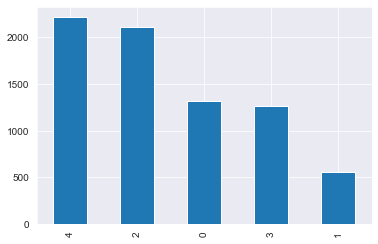

In [ ]:
print("The count of questions per cluster is:")
print(gsm_train.cluster.value_counts())
gsm_train.cluster.value_counts().plot(kind="bar")

The count of questions per cluster is:
4    422
2    360
0    228
3    210
1     99
Name: cluster, dtype: int64


<AxesSubplot:>

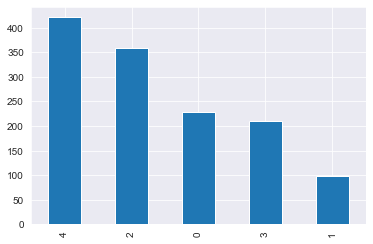

In [ ]:
test_clusters = kmeans.predict(matrix_test)
gsm_test["cluster"] = test_clusters
print("The count of questions per cluster is:")
print(gsm_test.cluster.value_counts())
gsm_test.cluster.value_counts().plot(kind="bar")

The count of questions per cluster is:
4    99
2    79
0    48
3    42
1    26
Name: cluster, dtype: int64


<AxesSubplot:>

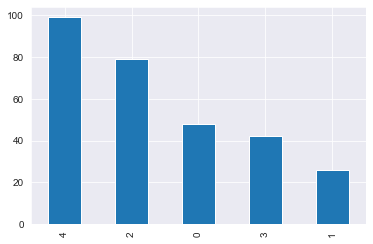

In [ ]:
test_clusters = kmeans.predict(matrix_reduced)
gsm_reduced["cluster"] = test_clusters
print("The count of questions per cluster is:")
print(gsm_reduced.cluster.value_counts())
gsm_reduced.cluster.value_counts().plot(kind="bar")

    Let's check which cluster our errors belong to on reduced gsm:

In [ ]:
cluster_results = pd.read_json(r"C:\Users\kaush\Desktop\fuck_you_chatPAL\pal\eval_results\baseline_cluster_results.jsonl",lines=True)
cluster_results = cluster_results.rename(columns={"input":"question"})

In [ ]:
cluster_results = cluster_results.merge(gsm_reduced, on="question")[["question","embedding", "cluster", "score"]]

In [ ]:
cluster_results_right = cluster_results[cluster_results["score"] == 1]
cluster_results_wrong = cluster_results[cluster_results["score"] == 0]

The count of questions per cluster is where score is 0:
4    30
2    19
3    17
0    13
1     7
Name: cluster, dtype: int64


<AxesSubplot:>

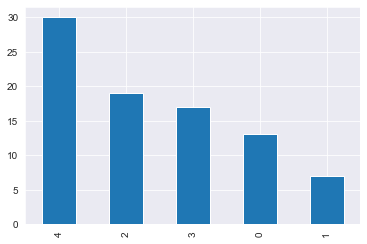

In [ ]:
print("The count of questions per cluster is where score is 0:")
print(cluster_results_wrong.cluster.value_counts())
cluster_results_wrong.cluster.value_counts().plot(kind="bar")

The count of questions per cluster is where score is 1:
4    69
2    60
0    35
3    25
1    19
Name: cluster, dtype: int64


<AxesSubplot:>

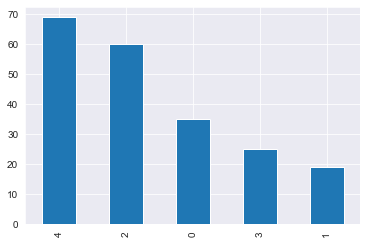

In [ ]:
print("The count of questions per cluster is where score is 1:")
print(cluster_results_right.cluster.value_counts())
cluster_results_right.cluster.value_counts().plot(kind="bar")

    Accuracy per cluster:

In [ ]:
cluster_results.groupby("cluster").mean()

,score
cluster,
0,0.729167
1,0.730769
2,0.759494
3,0.595238
4,0.696970


    Very interesting, we're doing slightly worse on Cluster 4 and way worse on Cluster 3.

    Our themes are:
        0. Food or weight
        1. Age
        2. Quantity and Proportion
        3. Time
        4. Money

    I need to find a way to improve performance on Cluster 3 and 4.
    One option is to remove one ICL exampple from Cluter 0, 1 and 2 and add  2 examples for Cluster 3 and one example for Cluster 4. The reason why we do badly on Cluster 4 is probably because it a lot of our questions belong to cluster 4 and we may not have prompted it enough. Moreover the highest performing cluster i.e. Cluster 2 might be  overly general...Cluster 3 is our second to bottom most frequent cluster.... the model might find it difficult to predict on this cluster since it is probably underrepresented in the prompt....There might be conversion or fraction issues as well....It might be that the model finds these types of problems complicated in general / most of the "each" type problems are in this cluster....
    I need to find more options......

In [ ]:
def filter_qs_by_col_analyze(df, column, test_list):
    #results is a df
    questions = df.question.values.tolist()
    test_list = set(test_list)
    col_qs = []
    not_col_qs = []
    index_flag = []
    for entry in questions:
        test_string = entry.lower()
        res = any(element in test_string for element in test_list)
        if res:
            index_flag.append(1)
        else:
            index_flag.append(0)
    df[column] = index_flag
    #Analysis
    print(f"Number of {column} questions: {len(df[df[column]==1])}")
    print(f"Number of NOT {column} questions: {len(df[df[column]==0])}")
    col_true_score1 = len(df[(df[column]==1) & (df["score"]==1)])
    col_true_score0 = len(df[(df[column]==1) & (df["score"]==0)])
    col_true_pct_correct = col_true_score1 / (col_true_score1 + col_true_score0)
    print(f"Accuracy for {column} questions: {col_true_pct_correct*100}%")
    col_false_score1 = len(df[(df[column]==0) & (df["score"]==1)])
    col_false_score0 = len(df[(df[column]==0) & (df["score"]==0)])
    col_false_pct_correct = col_false_score1 / (col_false_score1 + col_false_score0)
    print(f"Accuracy for NOT {column} questions: {col_false_pct_correct*100}%")
    print(f"Overall accuracy for this dataset is {len(df[df['score']==1]) / len(df)*100}%")
    return df

In [ ]:
x = filter_qs_by_col_analyze(cluster_results, "money", ["money", "$", "dollar", "gold", "silver", "peso", "cents", "pennies", "nickels"])

Number of money questions: 106
Number of NOT money questions: 188
Accuracy for money questions: 70.75471698113208%
Accuracy for NOT money questions: 70.74468085106383%
Overall accuracy for this dataset is 70.74829931972789%


In [ ]:
x = filter_qs_by_col_analyze(cluster_results, "percent", ["%", "percent", "percentage"])

Number of percent questions: 50
Number of NOT percent questions: 244
Accuracy for percent questions: 70.0%
Accuracy for NOT percent questions: 70.90163934426229%
Overall accuracy for this dataset is 70.74829931972789%


In [ ]:
x = filter_qs_by_col_analyze(cluster_results, "time", ["day", "week", "month", "year", "minute", "second", "time"])

Number of time questions: 164
Number of NOT time questions: 130
Accuracy for time questions: 69.51219512195121%
Accuracy for NOT time questions: 72.3076923076923%
Overall accuracy for this dataset is 70.74829931972789%


In [ ]:
x = filter_qs_by_col_analyze(cluster_results, "distance", ["feet", "km", "mph", "kilometer", "miles", "foot", "centimeter", "meter", "distance"])

Number of distance questions: 26
Number of NOT distance questions: 268
Accuracy for distance questions: 57.692307692307686%
Accuracy for NOT distance questions: 72.01492537313433%
Overall accuracy for this dataset is 70.74829931972789%


    This supports our previous intuition of adding more distance based questions.

In [ ]:
x = filter_qs_by_col_analyze(cluster_results, "weight", ["weigh", "pound", "kilogram", "grams", "weight", "ounce"])

Number of weight questions: 17
Number of NOT weight questions: 277
Accuracy for weight questions: 88.23529411764706%
Accuracy for NOT weight questions: 69.67509025270758%
Overall accuracy for this dataset is 70.74829931972789%


In [ ]:
x = filter_qs_by_col_analyze(cluster_results, "proportion", ["proportion", "/"])

Number of proportion questions: 21
Number of NOT proportion questions: 273
Accuracy for proportion questions: 52.38095238095239%
Accuracy for NOT proportion questions: 72.16117216117216%
Overall accuracy for this dataset is 70.74829931972789%


    This is our accuracy on questions containing the word "propotion", so it doesn't apply to questions that are in our cluster called proportion, and we observe that this is only 21 questions, so it's not a lot of support

In [ ]:
x = filter_qs_by_col_analyze(cluster_results, "times", ["times"])

Number of times questions: 46
Number of NOT times questions: 248
Accuracy for times questions: 69.56521739130434%
Accuracy for NOT times questions: 70.96774193548387%
Overall accuracy for this dataset is 70.74829931972789%


In [ ]:
x = filter_qs_by_col_analyze(cluster_results, "each", ["each"])

Number of eacj questions: 100
Number of NOT eacj questions: 194
Accuracy for eacj questions: 71.0%
Accuracy for NOT eacj questions: 70.61855670103093%
Overall accuracy for this dataset is 70.74829931972789%


#  TO DO: Visualize cluster wise errors

    The problem is that TSNE does not allow us to use a predict method on test data with the same model. We need to find a way to do this.
    POTENTIAL RESEARCH POSSIBLE

### PCA:

In [ ]:
def expand_embedding_to_df(df):
    return pd.DataFrame(df.embedding.values.tolist())

In [ ]:
pca = PCA()
pca.fit(expand_embedding_to_df(gsm_train))

PCA()

In [ ]:
pca.explained_variance_ratio_

array([4.82296584e-02, 3.08545419e-02, 2.04449641e-02, ...,
       2.51598360e-06, 1.63236333e-06, 1.86433041e-10])

Text(0, 0.5, 'Cumulative Explained Variance')

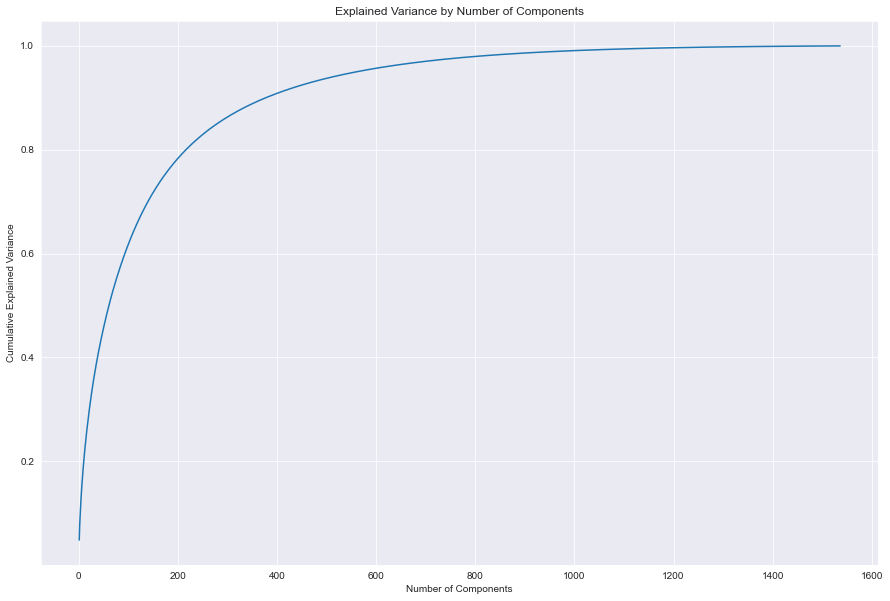

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), )
plt.title("Explained Variance by Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

    PCA is trash here. Look at the variance graph and cry

### Trying to visualize test cluster on top of train cluster:

    TSNE on gsm_train:

c:\Users\kaush\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

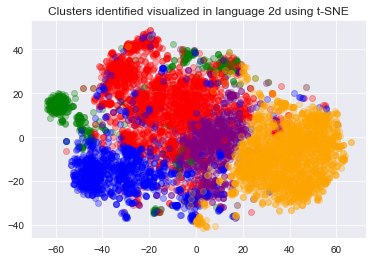

In [ ]:
n_components=2
perplexity=100
init="pca"
#TSNE
tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42, init=init, learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix_train)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

colors4 = ["purple", "green", "red", "blue"]
colors5 = ["purple", "green", "red", "blue", "orange"]
colors6 = ["purple", "green", "red", "blue", "orange", "yellow"]
colors7 = ["purple", "green", "red", "blue", "orange", "yellow", "pink"]

if n_clusters == 4:
    colors = colors4
elif n_clusters == 5:
    colors = colors5
elif n_clusters == 6:
    colors = colors6
elif n_clusters == 7:
    colors = colors7

for category, color in enumerate(colors):
    xs = np.array(x)[gsm_train.cluster == category]
    ys = np.array(y)[gsm_train.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=200)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [ ]:
vis_dims2

array([[ 20.881693 ,   8.569559 ],
       [ 48.213825 ,   8.960382 ],
       [ 42.913734 ,  -4.5023947],
       ...,
       [-49.355537 , -15.3892145],
       [ 36.353928 ,  -9.960058 ],
       [-55.813297 ,  17.678728 ]], dtype=float32)

In [65]:
#these 2 columns are our target variables
target1 = vis_dims2[:,0]
target2 = vis_dims2[:,1]

In [66]:
def check_quantile(col_var):
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,6))
    sns.distplot(col_var, ax=ax1)
    ax1.set(title=f'Distribution of the variable {col_var}')
    qqplot(col_var, ax=ax2, line='s')
    ax2.set(title=f'Theoritical quantiles of the variable {col_var}')

c:\Users\kaush\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


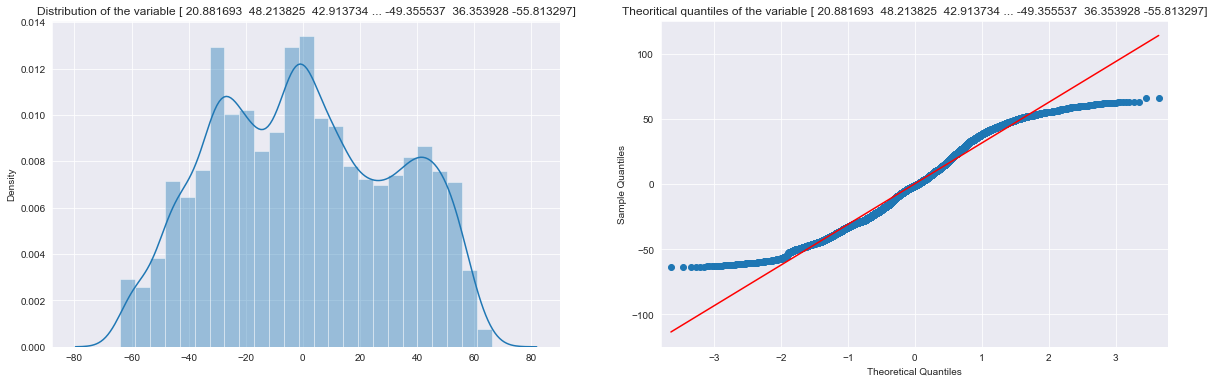

In [67]:
check_quantile(target1)

c:\Users\kaush\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


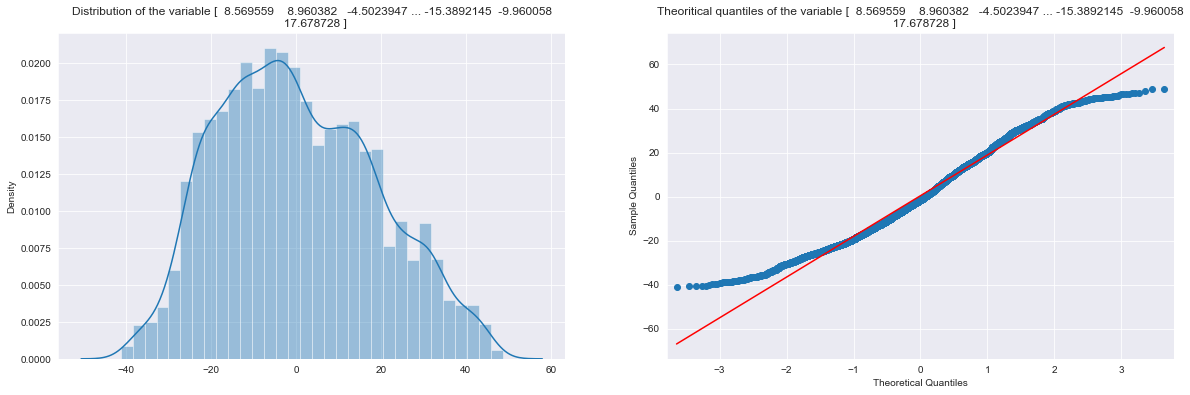

In [69]:
check_quantile(target2)

    These curves look pretty good and don't need log scaling.

### The following takes too long:

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

models = [LinearRegression(),
         Ridge(),
         HuberRegressor(),
         ElasticNetCV(),
         DecisionTreeRegressor(),
        #  RandomForestRegressor(), #takes too much time
         ]

# models2 = [ExtraTreesRegressor(),
#          GradientBoostingRegressor()]

In [82]:
from sklearn import model_selection
def train(model):
    kfold = model_selection.KFold(n_splits=5)
    pred = model_selection.cross_val_score(model, matrix_train, target1, cv=kfold, scoring='neg_mean_squared_error')
    cv_score = pred.mean()
    print('Model:',model)
    print('CV score:', abs(cv_score))

In [83]:
for model in models2:
    train(model)

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(matrix_train, target1, test_size=0.25, random_state=42)

In [ ]:
model1 = RandomForestRegressor()
model1.fit(x_train, y_train)
y_pred = model1.predict(x_test)

### Let's find which cluster most of our errors belong to:

    We'll have to train an MLP (neural network) to do this..... 